https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

In [ ]:
import logging
import numpy as np
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
data_directory = "drive/My Drive/MTP/data/"

In [ ]:
preprocessed_train_tsv = data_directory + "preprocessed_train.tsv"  #remove ‘content/’ from path then use 
train_data = pd.read_csv(preprocessed_train_tsv, sep='\t')
#X_valid = vectorizer.fit_transform(valid_data['Text'].to_numpy())
X_train = []
for index, row in train_data.iterrows():
  X_train.append(row['Text'])
X_train = np.array(X_train)
y_train = train_data['Label'].to_numpy()

In [ ]:
validation_tsv = data_directory + "preprocessed_valid.tsv"  #remove ‘content/’ from path then use 
valid_data = pd.read_csv(validation_tsv, sep='\t')
#X_valid = vectorizer.fit_transform(valid_data['Text'].to_numpy())
X_valid = []
for index, row in valid_data.iterrows():
  X_valid.append(row['Text'])
X_valid = np.array(X_valid)
y_valid = valid_data['Label'].to_numpy()

In [ ]:
data_train = X_train

data_test = X_valid

print('data loaded')

target_names = ['0', '1']

def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train)
data_test_size_mb = size_mb(data_test)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test), data_test_size_mb))
print("%d categories" % len(target_names))
print()

# split a training set and a test set
y_train, y_test = y_train, y_valid

data loaded
6936 documents - 0.979MB (training set)
1000 documents - 0.140MB (test set)
2 categories



In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')
def avgEmbed(x):
  count = 0
  allvecs = []

  for i in sent_tokenize(x): 
    temp = [] 
      
    # tokenize the sentence into words 
    for j in word_tokenize(i): 
        if j in words:
          allvecs.append(model[j]) 
  allvecs = np.array(allvecs)
  avg_vec = np.mean(allvecs, axis=0)
  return avg_vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from gensim.models import Word2Vec
print("Extracting features from the training data using a Word2Vec vectorizer")
t0 = time()
input_word2vec = []
for s in data_train:
  input_word2vec.append(s.split())
model = Word2Vec(input_word2vec, min_count=1, size=300)
words = list(model.wv.vocab)
X_train = [avgEmbed(sentence) for sentence in  data_train]
X_train = np.array(X_train)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = [avgEmbed(sentence) for sentence in  data_test]
X_test = np.array(X_test)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
feature_names = words

Extracting features from the training data using a Word2Vec vectorizer


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


done in 13.758378s at 0.071MB/s
n_samples: 6936, n_features: 300

Extracting features from the test data using the same vectorizer
done in 1.462211s at 0.096MB/s
n_samples: 1000, n_features: 300



In [ ]:
if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

In [ ]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    precision_score = metrics.precision_score(y_test, pred)
    print("precision_score:   %0.3f" % precision_score)

    recall_score = metrics.recall_score(y_test, pred)
    print("recall_score:   %0.3f" % recall_score)

    f1_score = metrics.f1_score(y_test, pred)
    print("f1_score:   %0.3f" % f1_score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    if True:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    if clf_descr in ['SGDClassifier', 'LinearSVC']:
        #curr_params = clf.get_params()
        clf_descr += '_penalty_' + clf.get_params()['penalty']
    return clf_descr, precision_score, recall_score, f1_score, train_time, test_time

In [ ]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
#results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
#results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.427s
test time:  0.001s
precision_score:   0.731
recall_score:   0.644
f1_score:   0.685
dimensionality: 300
density: 1.000000
confusion matrix:
[[416 112]
 [168 304]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.161s
test time:  0.002s
precision_score:   0.483
recall_score:   0.994
f1_score:   0.650
dimensionality: 300
density: 1.0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


train time: 0.349s
test time:  0.002s
precision_score:   0.734
recall_score:   0.608
f1_score:   0.665
dimensionality: 300
density: 1.000000
confusion matrix:
[[424 104]
 [185 287]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
          verbose=0)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.912s
test time:  0.002s
precision_score:   0.742
recall_score:   0.676
f1_score:   0.707
dimensionality: 300
density: 0.173333
confusion matrix:
[[417 111]
 [153 319]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


train time: 0.744s
test time:  0.003s
precision_score:   0.747
recall_score:   0.614
f1_score:   0.674
dimensionality: 300
density: 0.260000
confusion matrix:
[[430  98]
 [182 290]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


train time: 0.778s
test time:  0.003s
precision_score:   0.748
recall_score:   0.547
f1_score:   0.632
dimensionality: 300
density: 0.833333
confusion matrix:
[[441  87]
 [214 258]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.012s
test time:  0.004s
precision_score:   0.583
recall_score:   0.712
f1_score:   0.641
confusion matrix:
[[288 240]
 [136 336]]

Naive Bayes
________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
train time: 0.046s
test time:  0.007s
precision_score:   0.615
recall_score:   0.460
f1_score:   0.526
dimensionality: 300
density: 1.000000
confusion matrix:
[[392 136]
 [255 217]]

LinearSVC with L1-based feature selection
_______________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 2.121s
test time:  0.002s
precision_score:   0.720
recall_score:   0.655
f1_score:   0.686
confusion matrix:
[[408 120]
 [163 309]]



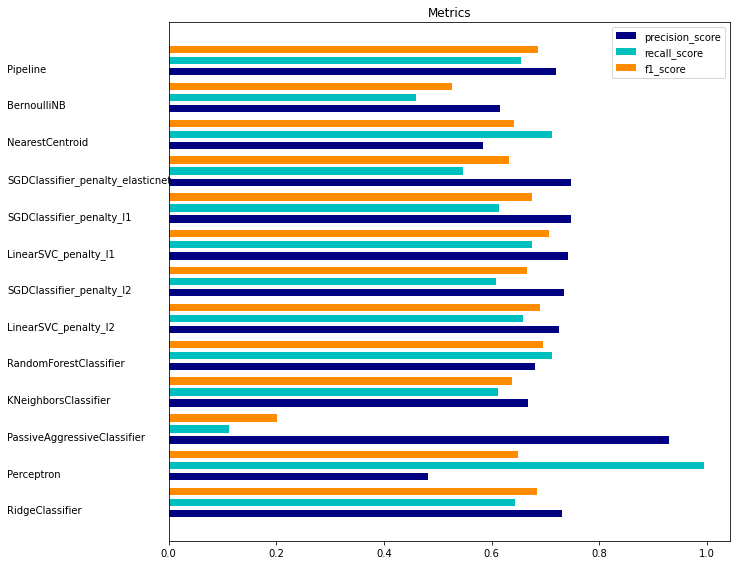

In [ ]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(6)]

clf_names, precision_score, recall_score, f1_score, training_time, test_time = results
#training_time = np.array(training_time) / np.max(training_time)
#test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Metrics")
plt.barh(indices, precision_score, .2, label="precision_score", color='navy')
plt.barh(indices + .3, recall_score, .2, label="recall_score",
         color='c')
plt.barh(indices + .6, f1_score, .2, label="f1_score", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [ ]:
df = pd.DataFrame()
df['Name'] = results[0]
df['Precision'] = results[1]
df['Recall'] = results[2]
df['F1_Score'] = results[3]
df['Training_time'] = results[4]
df['Test_time'] = results[5]

In [ ]:
df

,Name,Precision,Recall,F1_Score,Training_time,Test_time
0,RidgeClassifier,0.730769,0.644068,0.684685,0.426978,0.001174
1,Perceptron,0.482510,0.993644,0.649584,0.160771,0.001623
2,PassiveAggressiveClassifier,0.929825,0.112288,0.200378,0.195899,0.001755
3,KNeighborsClassifier,0.667436,0.612288,0.638674,0.264236,0.390860
4,RandomForestClassifier,0.680162,0.711864,0.695652,9.686154,0.043273
5,LinearSVC_penalty_l2,0.724942,0.658898,0.690344,0.552586,0.001792
6,SGDClassifier_penalty_l2,0.734015,0.608051,0.665122,0.348643,0.001881
7,LinearSVC_penalty_l1,0.741860,0.675847,0.707317,1.912414,0.001932
8,SGDClassifier_penalty_l1,0.747423,0.614407,0.674419,0.744033,0.002619
9,SGDClassifier_penalty_elasticnet,0.747826,0.546610,0.631579,0.778291,0.002561


In [ ]:
df.to_csv(data_directory + 'trained_word2vec_results.tsv', sep='\t')